In [1]:
import pandas as pd
import requests, uuid, json
import re
from langdetect import detect
from utils import translate

In [73]:
df = pd.read_csv('dataset.csv')
df

,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations
...,...,...,...,...
17652,Id-1708,Evolve Selection are currently recruiting for ...,Permanent,Manufacturing & Operations
17653,Id-18516,Therapy Area: Respiratory\r\r\r\nPackage: Nego...,Permanent,Science
17654,Id-13531,COMPANY\r\r\r\nA specialised health economics ...,Permanent,Medical Information and Pharmacovigilance
17655,Id-21805,Asha Mistry de Umbilical Life está reclutando ...,Permanent,Clinical Research


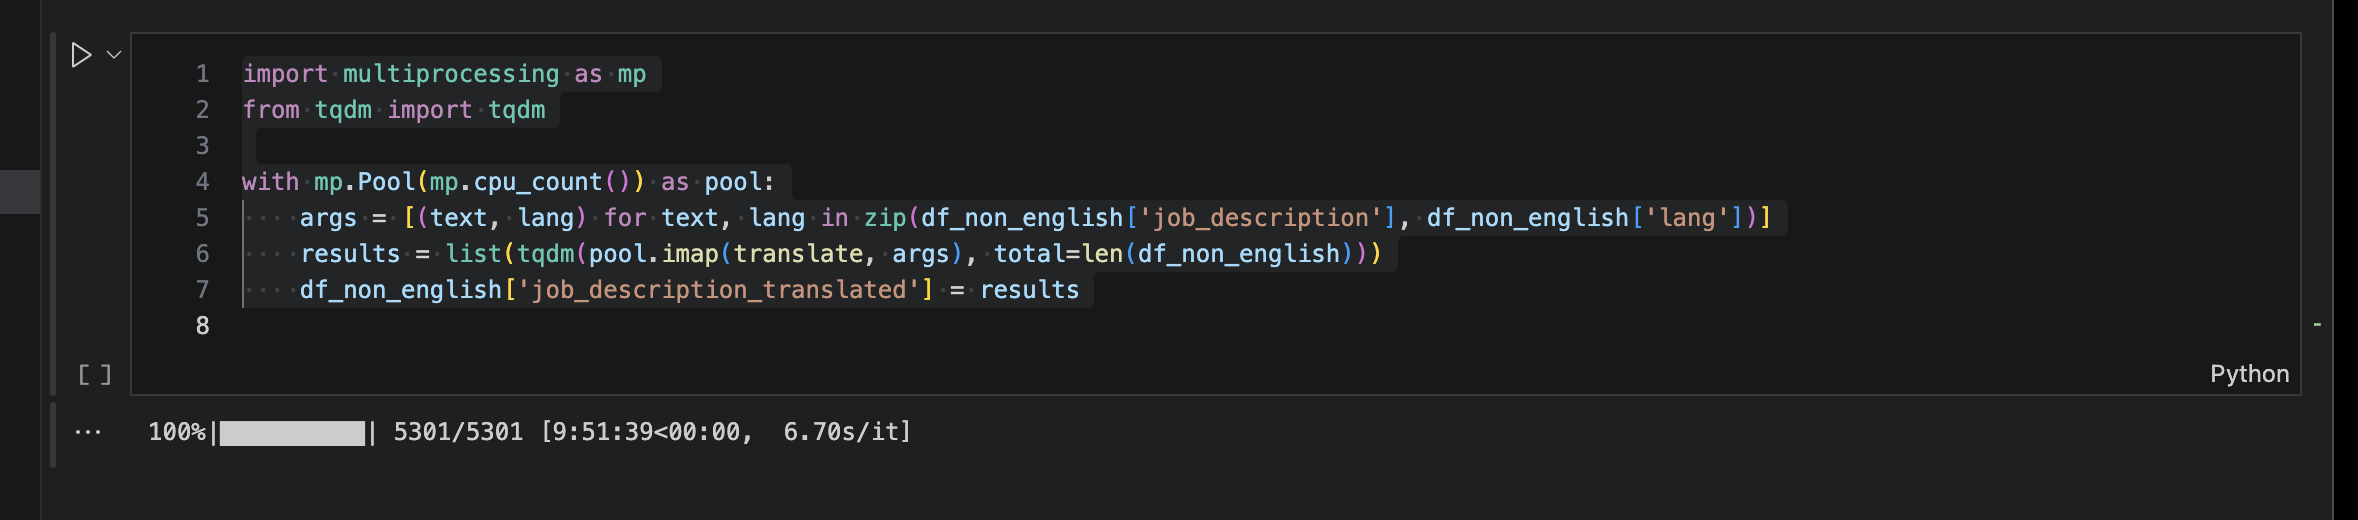

In [ ]:
import multiprocessing as mp
from tqdm import tqdm

with mp.Pool(mp.cpu_count()) as pool:
    args = [(text, lang) for text, lang in zip(df_non_english['job_description'], df_non_english['lang'])]
    results = list(tqdm(pool.imap(translate, args), total=len(df_non_english)))
    df_non_english['job_description_translated'] = results


100%|██████████| 5301/5301 [9:51:39<00:00,  6.70s/it]     


## Translated 

In [2]:
df = pd.read_csv('dataset_translated.csv')

In [3]:
df_english = df[df['lang'] == 'en'].copy()
df_non_english = df[df['lang'] != 'en'].copy()

In [4]:
df_english['job_description_translated'] = df_english['job_description']
df = pd.concat([df_english, df_non_english])
df.to_csv('dataset_translated.csv', index=False)

In [5]:
df_unique = df[['job_type','category','lang','job_description_translated']].drop_duplicates()
df_unique

,job_type,category,lang,job_description_translated
0,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en,Zest Scientific is searching for an accomplis...
1,Contract/Interim,Pharmaceutical Marketing,en,Asha Mistry of Umbilical Life is recruiting an...
2,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en,Sales Representative - Laser in der Medizinte...
3,Permanent,Manufacturing & Operations,en,Field Service Engineer - Life Science\r\r\r\nC...
4,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en,Due to increased business demand this award w...
...,...,...,...,...
17650,Permanent,Science,es,Veterinary pathologist with scientific respons...
17651,Permanent,Regulatory Affairs,fr,Experienced medical writing - Germany - Advice...
17652,Permanent,Manufacturing & Operations,fr,QMS specialists - German Switzerland - growing...
17653,Permanent,Manufacturing & Operations,de,"Alcon, United Kingdom\nWould you like to work ..."


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
import nltk          
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download(['punkt_tab','wordnet'])
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.porter = PorterStemmer()

        url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/american_spellings.json"
        self.american_british_dict = requests.get(url).json() 

    def __call__(self, doc):
        doc = re.sub(r'\W+', ' ', doc)
        doc = re.sub(r'\b\w{1,2}\b', '', doc)
        doc = re.sub(r'\d+', '', doc)
  
        words = []
        for t in word_tokenize(doc):
            word = self.wnl.lemmatize(t)
            word = self.american_british_dict.get(word, word)
            words.append(word)
        return words
        # return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
vectorizer = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),
    stop_words='english',
    strip_accents = 'unicode',
    )

X = vectorizer.fit_transform(df_unique['job_description_translated'])
vectorizer.get_feature_names_out()

print(len(vectorizer.get_feature_names_out()))
# for column in vectorizer.get_feature_names_out():
#     print(column)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/francismarkcayco/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/francismarkcayco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


13324


In [26]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(1500)
X_svd = svd.fit_transform(X)


In [27]:
variance_explained = svd.explained_variance_.cumsum()

0.8274089041515383


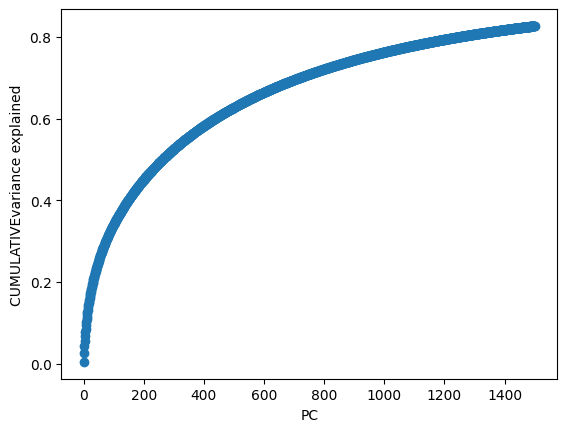

In [28]:
from matplotlib import pyplot as plt
plt.plot(range(1, len(variance_explained)+1), variance_explained, 'o-')
print(variance_explained[-1])
# plt.ylim(0,1)
plt.xlabel('PC')
plt.ylabel('CUMULATIVEvariance explained');


In [29]:
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
import scipy.sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import Pipeline
import scipy

In [30]:
encoder = LabelEncoder()
df_unique['job_type'] = encoder.fit_transform(df_unique['job_type'])
df_unique['category'] = encoder.fit_transform(df_unique['category'])

y = df_unique[['job_type','category']]

df_unique

,job_type,category,lang,job_description_translated
0,4,6,en,Zest Scientific is searching for an accomplis...
1,1,5,en,Asha Mistry of Umbilical Life is recruiting an...
2,4,6,en,Sales Representative - Laser in der Medizinte...
3,4,2,en,Field Service Engineer - Life Science\r\r\r\nC...
4,4,6,en,Due to increased business demand this award w...
...,...,...,...,...
17650,4,10,es,Veterinary pathologist with scientific respons...
17651,4,9,fr,Experienced medical writing - Germany - Advice...
17652,4,2,fr,QMS specialists - German Switzerland - growing...
17653,4,2,de,"Alcon, United Kingdom\nWould you like to work ..."


In [31]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(X_svd, y, test_size=1 - train_ratio)


x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(
    x_train.shape,
    y_train.shape,
    # x_val.shape,
    # y_val.shape,
    x_test.shape,
    y_test.shape,
)

# for set_ in [y_train, y_val, y_test, x_test, x_val, x_train]:
#     print(np.argwhere(np.isnan(set_)))

(7083, 1500) (7083, 2) (945, 1500) (945, 2)


In [32]:
def f1_multiclass_multioutput(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean([f1_score(y_true[:, i], y_pred[:, i], average='micro') for i in range(y_true.shape[1])])

### Version 1

In [33]:

models = [
    # (
    #     "LogisticRegression",
    #     LogisticRegression(),
    #     {
    #         # 'estimator__C': [0.1, 1, 10],
    #         # 'estimator__max_iter': [100, 1000, 10000],
    #         # 'estimator__penalty': ['l1', 'l2'],
    #     }
    # ),
    (
        "DecisionTreeClassifier",
        DecisionTreeClassifier(),
        {
            'max_depth': [2, 5, 10],
            'min_samples_split': [2, 10, 100],
        }
    ),
    (
        "RandomForestClassifier",
        RandomForestClassifier(),
        {
            'n_estimators': [5, 10],
            'max_depth': [10, 100, 1000],
            'min_samples_split': [2, 10, 100],
        }
    ),
    (
        "KNeighborsClassifier",
        KNeighborsClassifier(),
        {
            'n_neighbors': [5, 10, 100],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        }
    ),
    # (
    #     "GradientBoostingClassifier",
    #     GradientBoostingClassifier(),
    #     {
    #         'estimator__n_estimators': [100, 1000],
    #         'estimator__max_depth': [10, 100, 1000],
    #         'estimator__min_samples_split': [2, 10, 100],
    #     }
    # ),
    # (
    #     "SVC",
    #     SVC(),
    #     {
    #         'estimator__C': [0.1, 1, 10],
    #         'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #     }
    # ),
    # (
    #     "LogRegCV",
    #     LogisticRegressionCV(),
    #     {
    #         'estimator__Cs': [10, 100],
    #         'estimator__max_iter': [100, 1000, 10000],
    #         'estimator__penalty': ['l1', 'l2'],
    #     }
    # )
]

In [34]:
for model_name, model, param_grid in models:
    clf = RandomizedSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring=make_scorer(f1_multiclass_multioutput)) # , verbose=3
    clf.fit(x_train, y_train)
    score = clf.score(x_val, y_val)
    print(clf.best_estimator_, clf.best_params_)
    print(score)
    # clf.fit(x_train, y_train)

    # k_fold = K
    # scores = cross_validate(clf, x_train, y_train, cv=5, scoring=['f1_weighted'])
    # print(scores)
    # print(f"Best parameters for {model_name}: {clf.best_params_}")
    # print(f"Best score for {model_name}: {clf.best_score_}")

    # y_pred = clf.predict(x_val)

    # print(f"Validation score for {model_name}: {clf.score(x_val, y_val)}")
    # print(f"Test score for {model_name}: {clf.score(x_test, y_test)}")
    # print("\n")

/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


DecisionTreeClassifier(max_depth=5) {'min_samples_split': 2, 'max_depth': 5}
0.6698446327683616
RandomForestClassifier(max_depth=1000, min_samples_split=10, n_estimators=10) {'n_estimators': 10, 'min_samples_split': 10, 'max_depth': 1000}
0.6437146892655368
KNeighborsClassifier(algorithm='kd_tree', n_neighbors=10) {'weights': 'uniform', 'n_neighbors': 10, 'algorithm': 'kd_tree'}
0.7090395480225988


### Version 2

In [ ]:
param_grid = [
    {
        "clf": [DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreeClassifier(), ExtraTreesClassifier()], #
        'clf__max_depth': [10, 100, 1000],
        'clf__min_samples_split': [2, 10, 100],
    },
    {
        "clf": [KNeighborsClassifier()],
        'clf__n_neighbors': [5, 10, 100],
        'clf__weights': ['uniform', 'distance'],
        'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    },
    # {
    #     "clf": [RadiusNeighborsClassifier()],
    #     'clf__radius': range(1,100),
    #     'clf__weights': ['uniform', 'distance'],
    #     'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # }
]

In [40]:
steps = [('clf', None)]
pipe = Pipeline(steps)
clf = RandomizedSearchCV(pipe, param_distributions=param_grid,n_iter=100, cv=5, n_jobs=-1, scoring=make_scorer(f1_multiclass_multioutput), verbose=1) # ,

clf.fit(x_train, y_train)


score = clf.score(x_test, y_test)
print(score)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.7137566137566137


In [38]:
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__min_samples_split,param_clf__max_depth,param_clf,param_clf__weights,param_clf__n_neighbors,param_clf__algorithm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.877991,0.040363,0.025419,0.018357,2.0,10.0,DecisionTreeClassifier(),NaN,NaN,NaN,"{'clf__min_samples_split': 2, 'clf__max_depth'...",0.672900,0.675371,0.669019,0.667373,0.667373,0.670407,0.003200,23
1,11.039586,0.321807,0.015621,0.015896,10.0,10.0,DecisionTreeClassifier(),NaN,NaN,NaN,"{'clf__min_samples_split': 10, 'clf__max_depth...",0.677841,0.676782,0.673253,0.665960,0.670198,0.672807,0.004359,21
2,10.609963,0.073944,0.007621,0.002338,100.0,10.0,DecisionTreeClassifier(),NaN,NaN,NaN,"{'clf__min_samples_split': 100, 'clf__max_dept...",0.672900,0.672900,0.665490,0.671257,0.670198,0.670549,0.002730,22
3,17.749555,0.278952,0.006710,0.002866,2.0,100.0,DecisionTreeClassifier(),NaN,NaN,NaN,"{'clf__min_samples_split': 2, 'clf__max_depth'...",0.624559,0.631263,0.635145,0.630650,0.629944,0.630312,0.003394,42
4,17.466706,0.594476,0.007136,0.005329,10.0,100.0,DecisionTreeClassifier(),NaN,NaN,NaN,"{'clf__min_samples_split': 10, 'clf__max_depth...",0.638320,0.637615,0.634439,0.641949,0.631709,0.636806,0.003492,40
5,15.447199,0.697494,0.019164,0.003993,100.0,100.0,DecisionTreeClassifier(),NaN,NaN,NaN,"{'clf__min_samples_split': 100, 'clf__max_dept...",0.665138,0.648553,0.645730,0.657839,0.659605,0.655373,0.007195,33
6,18.547069,0.944699,0.014867,0.007018,2.0,1000.0,DecisionTreeClassifier(),NaN,NaN,NaN,"{'clf__min_samples_split': 2, 'clf__max_depth'...",0.629146,0.633733,0.638320,0.628178,0.639831,0.633842,0.004692,41
7,17.050404,0.383140,0.005089,0.001363,10.0,1000.0,DecisionTreeClassifier(),NaN,NaN,NaN,"{'clf__min_samples_split': 10, 'clf__max_depth...",0.636203,0.641143,0.638320,0.638065,0.632062,0.637159,0.002998,39
8,14.285342,0.461309,0.004587,0.001001,100.0,1000.0,DecisionTreeClassifier(),NaN,NaN,NaN,"{'clf__min_samples_split': 100, 'clf__max_dept...",0.664079,0.648200,0.645378,0.656780,0.663842,0.655656,0.007752,32
9,20.072384,0.211054,0.029738,0.004307,2.0,10.0,RandomForestClassifier(),NaN,NaN,NaN,"{'clf__min_samples_split': 2, 'clf__max_depth'...",0.643260,0.641496,0.636203,0.633121,0.647952,0.640407,0.005235,38


### Notes for Imee
- Label Encoder instead of multi label binarizer.  Also review the difference between (1)Label Binarizer and Encoder; and (2) Label Binarizer and Multi-Label Binarizer.
- The use of validation and test datasets are not used correctly.